# Reddit Comments Classification

In order to predict class labels for the comments we collected from Reddit, we chose to base our classifier on the Twitter classifier made public by Davidson et al., which was used in their research for the automatic hate-speech detection of Twitter posts. 

Beginning with the initial dataset of Twitter posts compiled by Davidson et al., which were labeled through crowd-sourcing as hate speech (0), offensive speech (1) or neither hate speech nor offensive speech (2), we extract features from the Twitter posts and train a logistic regression model to predict the class label of the posts.

We then apply the same feature extraction techniques to our dataset consisting of Reddit comments, along with the logistic regression model to predict class labels for our own data.

The complete Davidson et al. dataset can be found at https://github.com/t-davidson/hate-speech-and-offensive-language.

Davidson, Thomas et al. 2017. Automated Hate Speech Detection and the Problem of Offensive Language. Proceedings of the Eleventh International AAAI Conference on Web and Social Media. In ICWSM, 512-515.

@inproceedings{hateoffensive,
  title = {Automated Hate Speech Detection and the Problem of Offensive Language},
  author = {Davidson, Thomas and Warmsley, Dana and Macy, Michael and Weber, Ingmar}, 
  booktitle = {Proceedings of the 11th International AAAI Conference on Web and Social Media},
  series = {ICWSM '17},
  year = {2017},
  location = {Montreal, Canada},
  pages = {512-515}
  }

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
RANDOM_SEED = 697

# Loading the Davidson et al. Twitter Dataset to Train the Classifier

*** The modified Davidson et al. Twitter Hate Speech Classification code begins here. ***

<AxesSubplot:>

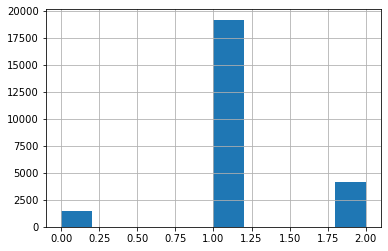

In [3]:
# twitter_df = pd.read_csv('Davidson_data.csv')
twitter_df = pd.read_csv('labeled_data.csv')
twitter_df['class'].hist()

In [4]:
tweets=twitter_df.tweet
len(tweets)

24783

# Feature Generation for the Davidson et al. Twitter Dataset

# Part 1 - Preprocess, Tokenize and TF-IDF Vectorization

In [5]:
'''The original Davidson et al. Twitter classification code has been slightly modified to
better account for the inherent differences between Twitter and Reddit comments.'''

stopwords=nltk.corpus.stopwords.words("english")
stemmer = PorterStemmer()

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    
    '''ORIGINAL CODE UPDATED: A bug in the original code was updated here,
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip() was changed to
    tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()'''
    
    tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    
    '''ORIGINAL CODE UPDATED: A bug in the original code was updated here,
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip() was changed to
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()'''
    
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/Users/cdallago/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


# Part 2 - POS Tagging

In [6]:
'''The original Davidson et al. Twitter classification code has been slightly modified to
better account for the inherent differences between Twitter and Reddit comments.'''

#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)
    
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75
    )

#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

# Part 3 - Sentiment Analysis and Text & Readability Scores

In [7]:
'''The original Davidson et al. Twitter classification code has been slightly modified to
better account for the inherent differences between Twitter and Reddit comments.'''

#Finally we get sentiment analysis and other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    words = preprocess(tweet)
    
    # Text and Readability feature scores 
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
        
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0]]
    
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls"]

feats = get_feature_array(tweets)

In [8]:
#Now join them all up to create the final matrix
M = np.concatenate([tfidf,pos,feats],axis=1)
M.shape

(24783, 11550)

In [9]:
'''These feature names are unnecessary for running the model but allow us to better 
visualize the features.'''

# Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the Model on the Davidson et al. Twitter Dataset

The Twitter hate speech detection model was selected by Davidson et al. used a logistic regression pipeline with an L1 penalty to select the best features and reduce dimensionality, and L2 regularization to predict the class label. They did, however, find that Logistic Regression and LinearSVC models performed similarly, and through testing we decided that a LinearSVC model results in a more accurate classification of our collected Reddit comments, so we chose this method. 

In [10]:
X = pd.DataFrame(M)
y = twitter_df['class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.3)

In [11]:
'''While Davidson et al. did not use a LinearSVC model in their final classifier, they did
include a LinearSVC model with the following parameters in their documentation.'''

svc_clf = LinearSVC(loss='squared_hinge',
                C=0.01,
                multi_class='ovr',
                class_weight='balanced')

In [12]:
model = svc_clf.fit(X_train, y_train)

/Users/cdallago/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [13]:
y_preds = model.predict(X_test)

# Evaluating the Davidson et al. Twitter Classification Results

In [14]:
report = classification_report(y_test, y_preds)

In [15]:
print(report)

              precision    recall  f1-score   support

           0       0.38      0.40      0.39       438
           1       0.94      0.93      0.93      5741
           2       0.83      0.88      0.85      1256

    accuracy                           0.89      7435
   macro avg       0.72      0.73      0.73      7435
weighted avg       0.89      0.89      0.89      7435



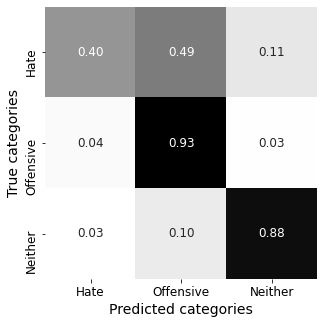

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

In their analysis, Davidson et al. write that, “far fewer tweets are classified as more 
offensive or hateful than their true category...suggesting that the model is biased towards 
classifying tweets as less hateful or offensive than the human coders.”

<AxesSubplot:>

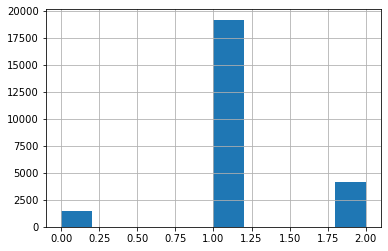

In [17]:
#True Davidson et al. Twitter distribution
y.hist()

<AxesSubplot:>

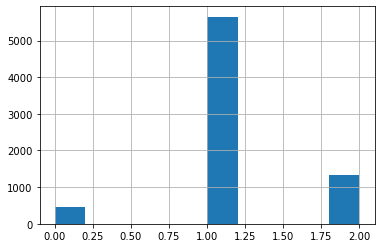

In [18]:
#Predicted Davidson et al. Twitter distribution
pd.Series(y_preds).hist()

*** The modified Davidson et al. Twitter Hate Speech Classification code ends here. ***

# Load, Vectorize and Transform the Reddit Comments to Apply the Classifier

*** Our Reddit Comment Classification code begins here. ***

In [19]:
comments_df = pd.read_csv('comments_df.csv')
comments = comments_df.body
len(comments)

273461

In [20]:
'''This block of code takes a while to run, as it performs all three steps of feature
extraction.'''

# Using the same methods as above, we construct a tfidf matrix using the vectorizer 
# and get relevant scores.

vectorizer.fit(tweets)
comments_tfidf = vectorizer.transform(comments).toarray()
comments_vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
comments_idf_vals = vectorizer.idf_
comments_idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

# Similarly we tokenize the comments to get the POS tags
comment_tags = []
for t in comments:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    comment_tags.append(tag_str)

# Then construct a POS TF matrix using the pos_vectorizer from above, resulting in a vocab 
# dictionary

pos_vectorizer.fit(pd.Series(tweet_tags))
comments_pos = pos_vectorizer.transform(pd.Series(comment_tags)).toarray()
comments_pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

# Finally we get the sentiment and other features
comments_feats = get_feature_array(comments)

# Join them up as above, and check to make sure each row is of the same length as in the
# Davidson et al. dataset so that the model will run
comments_M = np.concatenate([comments_tfidf,comments_pos,comments_feats],axis=1)
comments_M.shape

/Users/cdallago/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(273461, 11550)

In [21]:
'''Again, this is unnecessary for running the model but allows us to better visualize the
features.'''

#Finally get a list of variable names
comments_variables = ['']*len(comments_vocab)
for k,v in comments_vocab.items():
    comments_variables[v] = k

comments_pos_variables = ['']*len(comments_pos_vocab)
for k,v in comments_pos_vocab.items():
    comments_pos_variables[v] = k

comments_feature_names = comments_variables+comments_pos_variables+other_features_names
# comments_feature_names

# Running the Model to Predict Reddit Class Labels

In [22]:
comment_labels = model.predict(comments_M)

In [23]:
# Add the class labels into the original comments dataframe
comments_df['label'] = comment_labels

<AxesSubplot:>

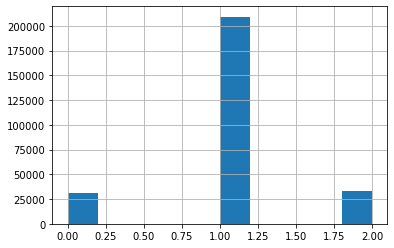

In [24]:
# Distribution of Reddit dataset
comments_df['label'].hist()

In [60]:
'''Uncomment to create a CSV of the raw comments dataset with class labels.'''
# comments_df.to_csv('comments_df_labeled.csv')

'Uncomment to create a CSV of the raw comments dataset with class labels.'